In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import panda_datasets, panda_baseline_models, panda_baseline_training
from lib.ekf import KalmanFilterNetwork
from fannypack import utils
from lib import dpf
from lib.panda_models import PandaDynamicsModel, PandaEKFMeasurementModel
from lib.fusion import CrossModalWeights
import lib.panda_kf_training as training
from lib.fusion import KalmanFusionModel



In [5]:
blackout = 0.8

# Experiment configuration
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
    'image_blackout_ratio': blackout
}

In [15]:
experiment_names = ["fusion_poe_blackout_{}_0".format(blackout), "fusion_poe_blackout_{}_1".format(blackout), "fusion_weighted_blackout_{}_1".format(blackout)]
fusion_type = ["poe", "poe", "weighted"]


In [7]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

# eval_trajectories = eval_trajectories[70:90]

In [16]:
# image_modality_model
image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=64)
image_dynamics = PandaDynamicsModel(use_particles=False)
image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# force_modality_model
force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=64)
force_dynamics = PandaDynamicsModel(use_particles=False)
force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

weight_model = CrossModalWeights()

fusion_models = []
buddies = []

for i, f_type in enumerate(fusion_type):
    model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
    buddy = fannypack.utils.Buddy(experiment_names[i],
                                  model,
                                optimizer_names=["im_meas", "force_meas",
                                "im_dynamics", "force_dynamics",
                                "force_ekf", "im_ekf",
                                "fusion"],
                                  load_checkpoint=True,
                                  )
    buddy.load_checkpoint("phase_4_fusion")
    fusion_models.append(model)
    buddies.append(buddy)



[buddy-fusion_poe_blackout_0.8_0] Using device: cuda
[buddy-fusion_poe_blackout_0.8_0] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.8_0-0000000000128145.ckpt


/scr-ssd/filter/fannypack/fannypack/utils/_buddy_mixins/_checkpointing.py:252: UserWarning: Checkpoint loading: overriding optimizer names.
  warnings.warn("Checkpoint loading: overriding optimizer names.")


[buddy-fusion_poe_blackout_0.8_0] Loaded checkpoint at step: 128145
[buddy-fusion_poe_blackout_0.8_0] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.8_0-phase_4_fusion.ckpt
[buddy-fusion_poe_blackout_0.8_0] Loaded checkpoint at step: 128145
[buddy-fusion_poe_blackout_0.8_1] Using device: cuda
[buddy-fusion_poe_blackout_0.8_1] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.8_1-0000000000087555.ckpt
[buddy-fusion_poe_blackout_0.8_1] Loaded checkpoint at step: 87555
[buddy-fusion_poe_blackout_0.8_1] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.8_1-phase_4_fusion.ckpt
[buddy-fusion_poe_blackout_0.8_1] Loaded checkpoint at step: 87555
[buddy-fusion_weighted_blackout_0.8_1] Using device: cuda
[buddy-fusion_weighted_blackout_0.8_1] Read checkpoint from path: checkpoints/fusion_weighted_blackout_0.8_1-0000000000087555.ckpt
[buddy-fusion_weighted_blackout_0.8_1] Loaded checkpoint at step: 87555
[buddy-fusion_weighted_blackout_0.8_1] Read checkpoint fr

In [11]:
pred_list = []
actual_list = []


fusion_poe_blackout_0.8_0


No handles with labels found to put in legend.


(10, 240, 2)


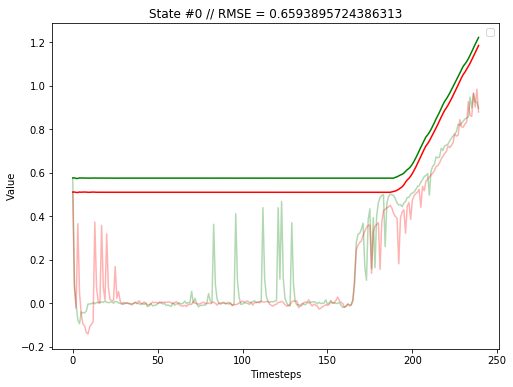

No handles with labels found to put in legend.


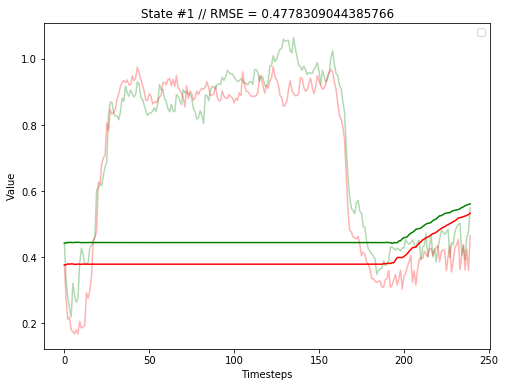


fusion_poe_blackout_0.8_1


No handles with labels found to put in legend.


(10, 240, 2)


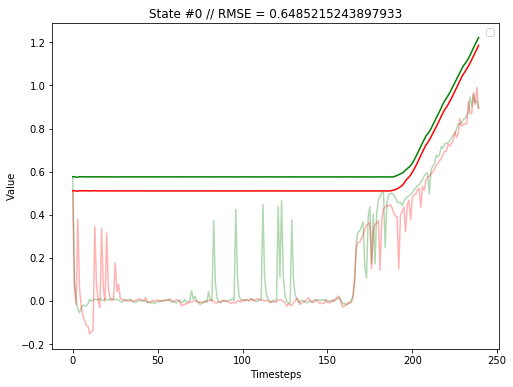

No handles with labels found to put in legend.


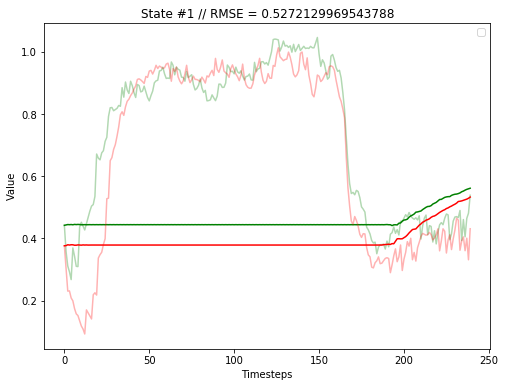


fusion_weighted_blackout_0.8_1


No handles with labels found to put in legend.


(10, 240, 2)


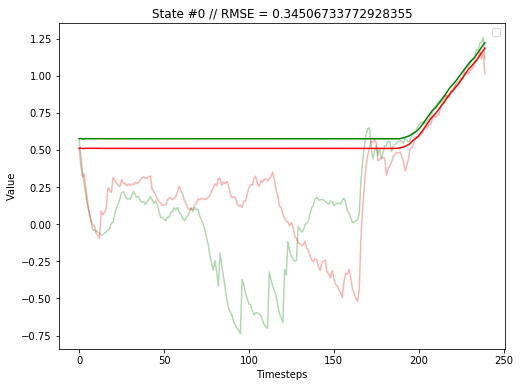

No handles with labels found to put in legend.


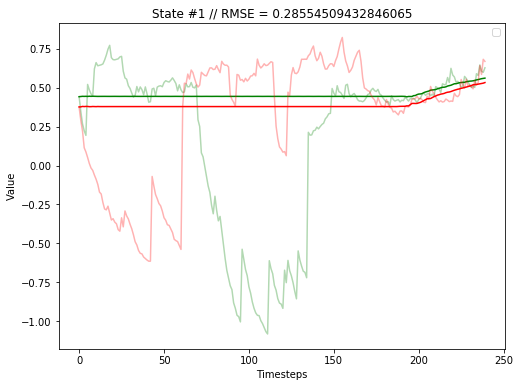

In [19]:
for i in range(len(fusion_models)):
    print(experiment_names[i]) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, 
                                       true_initial=True, init_state_noise=0.0)
    pred_list.append(pred)
    actual_list.append(actual)
    training.eval_rollout(pred, actual, plot=True, plot_traj=[1,2])
    print("")

In [13]:
experiment_name = "fusion_ekf_blackout_{}_0".format(blackout)
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
    'image_blackout_ratio': blackout
}
measurement = PandaEKFMeasurementModel()
dynamics = PandaDynamicsModel(use_particles=False)
ekf = KalmanFilterNetwork(dynamics, measurement)
print("Creating model...")
buddy = fannypack.utils.Buddy(experiment_name,
                              ekf,
                              optimizer_names=["ekf", "dynamics", "measurement"],
                              load_checkpoint=True,
                              )

buddy.load_checkpoint("phase_3_e2e")

Creating model...
[buddy-fusion_ekf_blackout_0.8_0] Using device: cuda
[buddy-fusion_ekf_blackout_0.8_0] Read checkpoint from path: checkpoints/fusion_ekf_blackout_0.8_0-0000000000116850.ckpt
[buddy-fusion_ekf_blackout_0.8_0] Loaded checkpoint at step: 116850
[buddy-fusion_ekf_blackout_0.8_0] Read checkpoint from path: checkpoints/fusion_ekf_blackout_0.8_0-phase_3_e2e.ckpt
[buddy-fusion_ekf_blackout_0.8_0] Loaded checkpoint at step: 116850


True

No handles with labels found to put in legend.


(10, 240, 2)


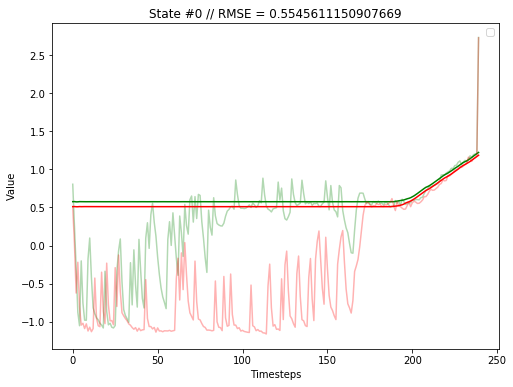

No handles with labels found to put in legend.


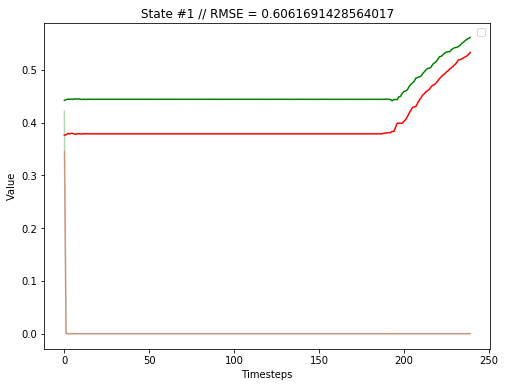

In [14]:
pred, actual = training.rollout_kf(ekf, eval_trajectories, true_initial=True, init_state_noise=0.2)
training.eval_rollout(pred, actual, plot=True,plot_traj=[1,2])

In [3]:
# Experiment configuration
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
    'sequential_image_rate': 5,
}

In [4]:
experiment_names = ["fusion_poe_seq5_0", "fusion_weighted_seq5_0" ]
fusion_type = ["poe", "weighted"]

eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)




In [7]:
# image_modality_model
image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=64)
image_dynamics = PandaDynamicsModel(use_particles=False)
image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# force_modality_model
force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=64)
force_dynamics = PandaDynamicsModel(use_particles=False)
force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

weight_model = CrossModalWeights()

fusion_models_seq5 = []
buddies_seq5 = []

for i, f_type in enumerate(fusion_type):
    model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
    buddy = fannypack.utils.Buddy(experiment_names[i],
                                  model,
                                optimizer_names=["im_meas", "force_meas",
                                "im_dynamics", "force_dynamics",
                                "force_ekf", "im_ekf",
                                "fusion"],
                                  load_checkpoint=True,
                                  )
    buddy.load_checkpoint("phase_4_fusion")
    fusion_models_seq5.append(model)
    buddies_seq5.append(buddy)



[buddy-fusion_poe_seq5_0] Using device: cuda
[buddy-fusion_poe_seq5_0] Read checkpoint from path: checkpoints/fusion_poe_seq5_0-0000000000101770.ckpt
[buddy-fusion_poe_seq5_0] Loaded checkpoint at step: 101770
[buddy-fusion_poe_seq5_0] Read checkpoint from path: checkpoints/fusion_poe_seq5_0-phase_4_fusion.ckpt
[buddy-fusion_poe_seq5_0] Loaded checkpoint at step: 101770
[buddy-fusion_weighted_seq5_0] Using device: cuda
[buddy-fusion_weighted_seq5_0] Read checkpoint from path: checkpoints/fusion_weighted_seq5_0-0000000000101770.ckpt
[buddy-fusion_weighted_seq5_0] Loaded checkpoint at step: 101770
[buddy-fusion_weighted_seq5_0] Read checkpoint from path: checkpoints/fusion_weighted_seq5_0-phase_4_fusion.ckpt
[buddy-fusion_weighted_seq5_0] Loaded checkpoint at step: 101770


In [8]:
pred_list_seq5=[]
actual_list_seq5=[]

In [9]:
for i in range(len(fusion_models_seq5)):
    print(experiment_names[i]) 
    pred, actual = training.rollout_kf(fusion_models_seq5[i], eval_trajectories, 
                                       true_initial=True, init_state_noise=0.0)
    pred_list_seq5.append(pred)
    actual_list_seq5.append(actual)
#     training.eval_rollout(pred, actual, plot=True, plot_traj=[1,2])
    print("")

fusion_poe_seq5_0
(10, 240, 2)

fusion_weighted_seq5_0
(10, 240, 2)



fusion_poe_seq5_0


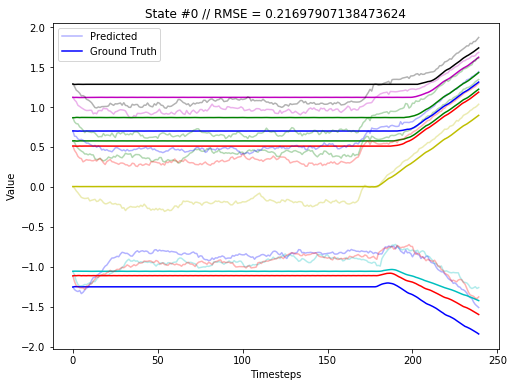

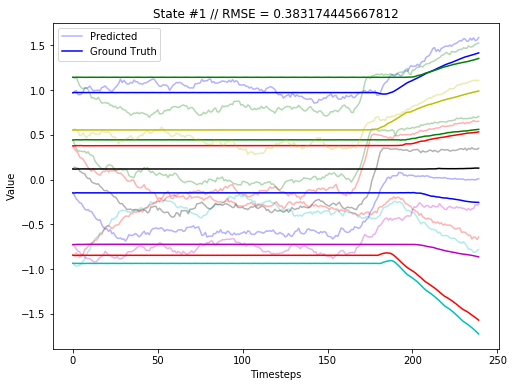

fusion_weighted_seq5_0


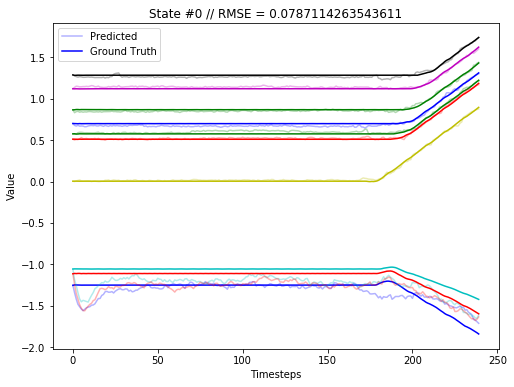

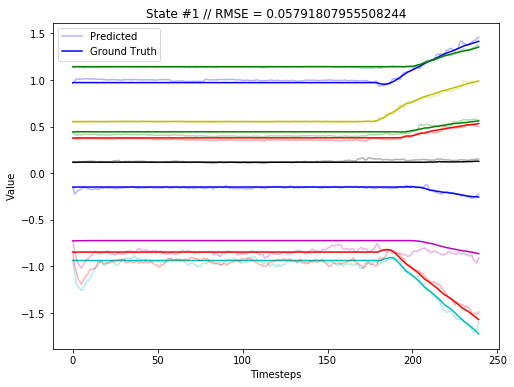

In [13]:
for i, (pred, actual) in enumerate(
                    zip(pred_list_seq5, actual_list_seq5)):
    print(experiment_names[i])
    training.eval_rollout(pred, actual, plot=True, start=0)